This notebook implements a submission with Gemma 2 9B IT model with some helper code to ensure the generated SVGs conform to the submission requirements. (See the [Evaluation](https://www.kaggle.com/competitions/drawing-with-llms/overview/evaluation) page for details on the submission requirements.)

To use this notebook interactively, you'll need to install some dependencies. First, *turn on* the Internet under **Session options** to the right. Then select the **Add-ons->Install Dependencies** menu above and click *Run*. A console should pop up with a running `pip` command. Wait for the dependencies to finish installing and then *turn off* the Internet before submitting.

In [2]:
#| default_exp core

In [3]:
#| export
import concurrent
import io
import logging
import re
import re2

import cairosvg
import kagglehub
import torch
from lxml import etree
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

svg_constraints = kagglehub.package_import('metric/svg-constraints')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Model:
    def __init__(self):
        # Quantization Configuration
        # # 4-bit quantization config
        # quantization_config = BitsAndBytesConfig(
        #     load_in_4bit=True,
        #     bnb_4bit_quant_type="nf4",
        #     bnb_4bit_use_double_quant=True,
        #     bnb_4bit_compute_dtype=torch.float16,
        # )
        # 8-bit quantization config
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,
        )
        
        self.model_path = kagglehub.model_download('google/gemma-2/Transformers/gemma-2-9b-it/2')
        # # if already downloaded the model, use following for model_path
        # # but seems failed when running on kaggle backend platform
        # self.model_path = '/kaggle/input/gemma-2/transformers/gemma-2-9b-it/2'
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        
        # with quantization
        # # 4-bit/8-bit quantization
        # self.model = AutoModelForCausalLM.from_pretrained(
        #     self.model_path,
        #     device_map="auto",
        #     quantization_config=quantization_config,
        # )
        # Use float16 or bfloat16 to load the model
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_path,
            device_map="auto",
            torch_dtype=torch.bfloat16,  # or torch.float16
        )

        # # no quantization
        # self.model = AutoModelForCausalLM.from_pretrained(
        #     self.model_path,
        #     device_map="auto",
        # )

        self.model.gradient_checkpointing_enable()

        print(self.model.hf_device_map)
        
        self.prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

<description>"{}"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 900

    
    
    # You could try increasing `max_new_tokens`
    def predict(self, description: str, max_new_tokens=512) -> str:
        def generate_svg():
            try:
                prompt = self.prompt_template.format(description)
                # print(f"Prompt: {prompt}")
                inputs = self.tokenizer(text=prompt, return_tensors="pt").to(DEVICE)

                # Clear the GPU cache before generating
                torch.cuda.empty_cache()
                with torch.no_grad():
                    output = self.model.generate(
                        **inputs,
                        max_new_tokens=max_new_tokens,
                        do_sample=True, # allow the model to randomly select tokens based on a probability distribution
                    )

                print(f"Output: {output}")
                output_decoded = self.tokenizer.decode(output[0], skip_special_tokens=True)
                print(f"Output_decoded: {output_decoded}")
                logging.debug('Output decoded from model: %s', output_decoded)

                matches = re.findall(r"<svg.*?</svg>", output_decoded, re.DOTALL | re.IGNORECASE)
                if matches:
                    svg = matches[-1]
                else:
                    return self.default_svg

                logging.debug('Unprocessed SVG: %s', svg)
                svg = self.enforce_constraints(svg)
                logging.debug('Processed SVG: %s', svg)
                # Ensure the generated code can be converted by cairosvg
                cairosvg.svg2png(bytestring=svg.encode('utf-8'))
                return svg
            except Exception as e:
                logging.error('Exception during SVG generation: %s', e)
                return self.default_svg

        # Execute SVG generation in a new thread to enforce time constraints
        with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
            future = executor.submit(generate_svg)
            try:
                return future.result(timeout=self.timeout_seconds)
            except concurrent.futures.TimeoutError:
                logging.warning("Prediction timed out after %s seconds.", self.timeout_seconds)
                return self.default_svg
            except Exception as e:
                logging.error(f"An unexpected error occurred: {e}")
                return self.default_svg

    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg

The following code tests the above model in a local mock-up of this competition's evaluation pipeline. It runs the model on a sample of instances defined in the `test.csv` file in the `kaggle_evaluation` package folder.

In [4]:
import kaggle_evaluation

logging.basicConfig(level=logging.INFO, force=True)
kaggle_evaluation.test(Model)

Creating Model instance...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

{'model.embed_tokens': 0, 'lm_head': 0, 'model.layers.0': 0, 'model.layers.1': 0, 'model.layers.2': 0, 'model.layers.3': 0, 'model.layers.4': 0, 'model.layers.5': 0, 'model.layers.6': 0, 'model.layers.7': 0, 'model.layers.8': 0, 'model.layers.9': 0, 'model.layers.10': 0, 'model.layers.11': 0, 'model.layers.12': 0, 'model.layers.13': 0, 'model.layers.14': 0, 'model.layers.15': 0, 'model.layers.16': 0, 'model.layers.17': 0, 'model.layers.18': 0, 'model.layers.19': 0, 'model.layers.20': 0, 'model.layers.21': 1, 'model.layers.22': 1, 'model.layers.23': 1, 'model.layers.24': 1, 'model.layers.25': 1, 'model.layers.26': 1, 'model.layers.27': 1, 'model.layers.28': 1, 'model.layers.29': 1, 'model.layers.30': 1, 'model.layers.31': 1, 'model.layers.32': 1, 'model.layers.33': 1, 'model.layers.34': 1, 'model.layers.35': 1, 'model.layers.36': 1, 'model.layers.37': 1, 'model.layers.38': 1, 'model.layers.39': 1, 'model.layers.40': 1, 'model.layers.41': 1, 'model.norm': 1}
Running inference tests...
Wr

Alternatively, you could use the code below to run the model over `train.csv` and see some generated images along with some debugging info. Turn down the logging level to `INFO` if you just want to see the images.

id,description
str,str
"""02d892""","""a purple forest at dusk"""
"""0dcd2e""","""gray wool coat with a faux fur…"
"""1e9ac1""","""a lighthouse overlooking the o…"
"""2b25db""","""burgundy corduroy pants with p…"
"""4e6a54""","""orange corduroy overalls"""


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dp.kaggle.net:443
DEBUG:urllib3.connectionpool:https://dp.kaggle.net:443 "POST /kaggle-jwt-handler/AttachDatasourceUsingJwtRequest HTTP/1.1" 200 None


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


{'model.embed_tokens': 0, 'lm_head': 0, 'model.layers.0': 0, 'model.layers.1': 0, 'model.layers.2': 0, 'model.layers.3': 0, 'model.layers.4': 0, 'model.layers.5': 0, 'model.layers.6': 0, 'model.layers.7': 0, 'model.layers.8': 1, 'model.layers.9': 1, 'model.layers.10': 1, 'model.layers.11': 1, 'model.layers.12': 1, 'model.layers.13': 1, 'model.layers.14': 1, 'model.layers.15': 1, 'model.layers.16': 1, 'model.layers.17': 1, 'model.layers.18': 1, 'model.layers.19': 1, 'model.layers.20': 1, 'model.layers.21': 1, 'model.layers.22': 1, 'model.layers.23': 1, 'model.layers.24': 1, 'model.layers.25': 1, 'model.layers.26': 'cpu', 'model.layers.27': 'cpu', 'model.layers.28': 'cpu', 'model.layers.29': 'cpu', 'model.layers.30': 'cpu', 'model.layers.31': 'cpu', 'model.layers.32': 'cpu', 'model.layers.33': 'cpu', 'model.layers.34': 'cpu', 'model.layers.35': 'cpu', 'model.layers.36': 'cpu', 'model.layers.37': 'cpu', 'model.layers.38': 'cpu', 'model.layers.39': 'cpu', 'model.layers.40': 'cpu', 'model.l

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

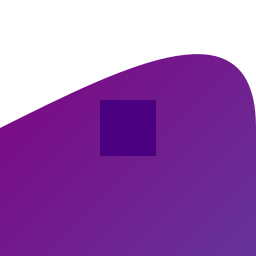

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

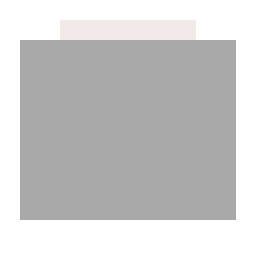

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

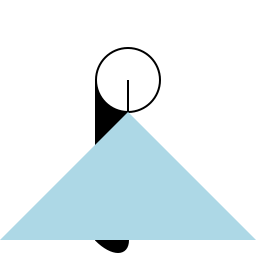

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

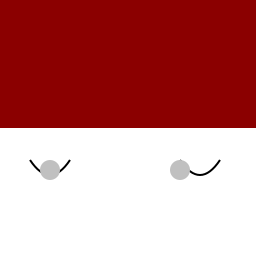

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

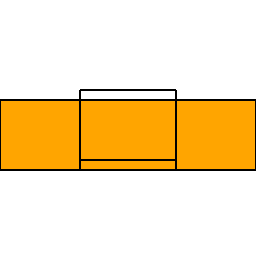

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

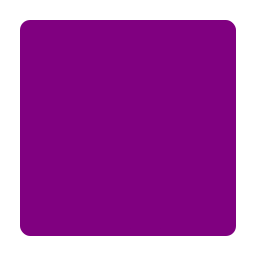

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

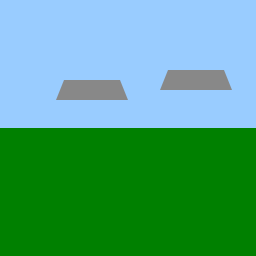

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

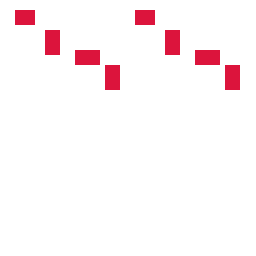

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

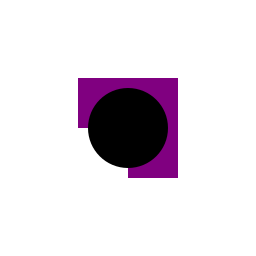

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

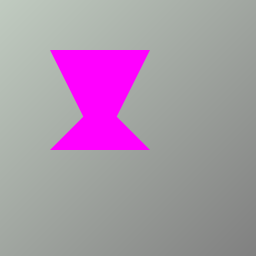

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

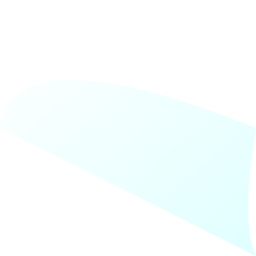

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

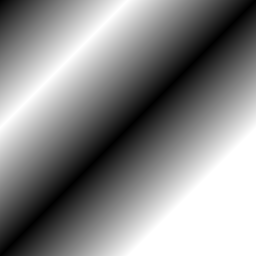

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

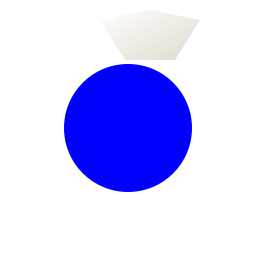

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

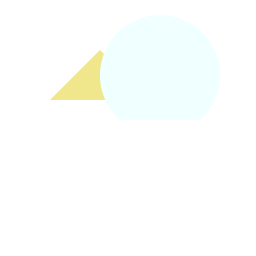

DEBUG:root:Output decoded from model: Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. 

Output: tensor([[     2,  38557,  75279,   3409,    577,  56157,   4319,    573,   2412,
           2793,   5966, 235269,   2183,  56582,    573,   2764,  24278, 235265,
            108, 235322,  39115, 235313,    108, 235287,   5231,  48965,  34762,
          66058,   4103,  14789,  10738,   4103,   2222,  10738,   4103,  18179,
          10738,   4103,   2684,  10738,   4103, 115204,  10738,   4103,    703,
          10738,   4103, 194449,  10738,   4103,  68047,  10738,   4103, 235264,
          10738,   4103, 219184,  10738,   4103, 135228,  44833,  10738,   4103,
           7282,  10738,   4103,  61510, 235376,    108, 235287,   5231,  48965,
          55249,  66058,   4103, 166159,  10738,   4103,   2791,  10738,   4103,
           3946,  10738,   4103,   6984,  10738,   4103,  18884,  10738,   4103,
          18884, 235290,   2791,  10738,   4103, 235258,  10738,   4103,  30559,
          10738,   4103,   1225,  10738,   4103, 235255,  10738,   4103, 235297,
          10738,   4

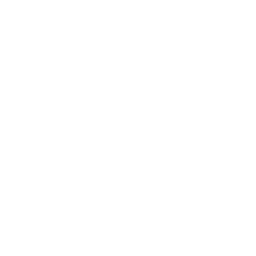

In [5]:
def generate():
    import polars as pl
    from IPython.display import SVG
    import time  # Import the time module
    
    logging.basicConfig(level=logging.DEBUG, force=True)
    
    train = pl.read_csv('/kaggle/input/drawing-with-llms/train.csv')
    display(train.head())
    
    model = Model()
    svgs = []
    for desc in train.get_column('description'):
        start_time = time.time()  # Record start time
        svg = model.predict(desc)
        end_time = time.time()    # Record end time
        elapsed_time = end_time - start_time # Calculate elapsed time
        print(f"Prediction time for description '{desc[:20]}...': {elapsed_time:.4f} seconds") # Print time
    
        try:
            display(SVG(svg))
        except Exception as e:
            print(e)
            continue

# # Uncomment and run the line below to see some generated images
generate()